In [131]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.io import savemat

In [132]:
def plot_boxplot(data,savepath= ".",name=None,p_value=None, ax=None, xticklabels=None):

    if ax is None:
        fig = plt.figure(figsize = (7,5),dpi=80)
        ax = fig.add_subplot(111)
        
    bp = ax.boxplot(data, patch_artist=True)
    
    for box in bp['boxes']:
        # change outline color
        box.set( color='k', linewidth=1)
        # change fill color
        box.set( facecolor = '#DCDCDC' )
    
    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='k', linewidth=2)
    
    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='k', linewidth=2)
    
    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='k', linewidth=2)
    
    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='k', markerfacecolor = '#DCDCDC', alpha=0.5)

    x1, x2 = 1, 2   
    y, h, col = np.array(data).max() , 1, 'k'
 
    if p_value is not None:
        plt.text((x1+x2)*.5, y+h, 'p=%.6f'%(p_value), ha='center', va='bottom', color=col)

    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xlabel("condition", fontsize = 16)
    plt.title(name)
    plt.ylabel("absolute selectivity (on-off)", fontsize = 16)
    plt.tight_layout()


In [133]:
def phi(_x,act="sigmoid"):
    if act == "sigmoid":
        return 1.0/(1.0+np.exp(-_x))
    elif act == "linear":
        r_max=10.0
        _x[_x<=0] = 0 # rectify at 0
        _x[_x>r_max] = r_max
        return _x
    else:
        raise ValueError

def run_model(circuit = "Go", condition=None, linear_activation=False, no_competition=False):

    # Parameters
    dt = .05                                      # Simulation time step
    nsteps = 50                                   # Number of simulation time steps
    N = 100                                       # Number of trials
    M = int(N/2)                                   # Number of Go/Nogo trials  
    PV_on = 2.0                                      # activation of PVs during the laser stimulation
    PV_on_time = 400
    PV_off_time = 500
    measure_from = 400                             # time step from which we start averaging
    tau_E = 1.0
    tau_I = 0.5 
    
    # set the weight
    if no_competition is True:
        W = 1.0      
    elif circuit == "Go":
        W = 13.0
    elif circuit == "NoGo":
        W = 5.0
        
    # set the type of activation function
    if linear_activation is True:
        act = "linear"
    else:
        act = "sigmoid"
        

    all_window_sel = []
    all_rates_1 = []
    all_rates_2 = []

    seeds = [763,82375,838,903489,5786,78634,38,276,9405,2716,409,852,847,736,945] # corresponding to different circuits
    
    for seed in seeds:
        np.random.seed(seed)
        # Input to the populations
        I_1 = np.ones((N))*0.1+np.random.randn(N)*0.1       # Input to Population 1 
        I_2 = np.ones((N))*0.1+np.random.randn(N)*0.1       # Input to Population 2 
        I_pref = np.ones((M))*0.5+np.random.randn(M)*0.1    # Input to population 1 during its preferred orientation
        I_1[:M] = I_pref                                    # The first 50 trials are those with the preferred stimulus   

            
        r_1 = abs(np.random.randn(N))                       # randomly initialise the rates in each trial
        r_2 = abs(np.random.randn(N))
        r_pv1 = abs(np.random.randn(N))                       # randomly initialise the rates in each trial
        r_pv2 = abs(np.random.randn(N))
        
        
        
        # record the rates
        rates_1 = []
        rates_2 = []
        rates_1.append(r_1.copy())
        rates_2.append(r_2.copy())

        for t in range(int(nsteps/dt)):
            if condition == "early":
                if (t>PV_on_time) and (t < PV_off_time):
                    PV = PV_on
                else: 
                    PV = 0.0
            elif condition == "entire":
                if (t>PV_on_time):
                    PV = PV_on
                else: 
                    PV = 0.0
            elif condition is None:
                PV = 0.0
                
                
            dr_pv1 = (-r_pv1 + phi(r_1,'linear'))/tau_I
            dr_pv2 = (-r_pv2 + phi(r_2,'linear'))/tau_I
            dr_1 = (-r_1 + phi(-W*r_pv2 + I_1 - PV, act))/tau_E
            dr_2 = (-r_2 + phi(-W*r_pv1 + I_2 - PV, act))/tau_E                
                

            r_1 += dt*dr_1
            r_2 += dt*dr_2
            r_pv1 += dt*dr_pv1
            r_pv2 += dt*dr_pv2

            rates_1.append(r_1.copy())
            rates_2.append(r_2.copy())

        
        window_mean_pref = np.mean(np.mean(np.array(rates_1)[measure_from:,:M]))        # take the average from time step "measure_from" in the first M trials (preferred stimulus)
        window_mean_nonpref = np.mean(np.mean(np.array(rates_1)[measure_from:,M:]))     # take the average from time step "measure_from" in the last M trials (nonpreferred stimulus)
        
        window_sel = (window_mean_pref - window_mean_nonpref)                  # calculate selectivity

        all_window_sel.append(window_sel)
        all_rates_1.append(np.array(rates_1).T)
        all_rates_2.append(np.array(rates_2).T)
                           
    results = {
        "all_rates_1" : all_rates_1,
        "all_rates_2" : all_rates_2,
        "all_window_sel" : all_window_sel,
        "pref" : window_mean_pref,
        "nonpref" : window_mean_nonpref
    }
    
    return results

In [134]:
results_none1 = run_model(circuit = "Go")
results_none2 = run_model(circuit = "NoGo")
rates_1_none = results_none1["all_rates_1"]
rates_2_none = results_none2["all_rates_1"]
trials = np.shape(rates_2_none)[0]*np.shape(rates_2_none)[1]
timesteps = np.shape(rates_2_none)[2]

rates_1_n = np.reshape(rates_1_none,(trials,timesteps))
rates_2_n = np.reshape(rates_2_none,(trials,timesteps))

In [135]:
pref_1_none = results_none1["pref"]
pref_2_none = results_none2["pref"]
nonpref_1_none = results_none1["nonpref"]
nonpref_2_none = results_none2["nonpref"]


In [136]:
results_early1 = run_model(circuit = "Go", condition="early")
results_early2 = run_model(circuit = "NoGo", condition="early")
rates_1_early = results_early1["all_rates_1"]
rates_2_early = results_early2["all_rates_1"]
rates_1_ea = np.reshape(rates_1_early,(trials,timesteps))
rates_2_ea = np.reshape(rates_2_early,(trials,timesteps))

In [137]:
results_entire1 = run_model(circuit = "Go", condition="entire")
results_entire2 = run_model(circuit = "NoGo", condition="entire")
rates_1_entire = results_entire1["all_rates_1"]
rates_2_entire = results_entire2["all_rates_1"]
rates_1_en = np.reshape(rates_1_entire,(trials,timesteps))
rates_2_en = np.reshape(rates_2_entire,(trials,timesteps))

In [138]:
def plot_panel_B(sel_1_early,sel_1_entire,sel_1_none,sel_2_early=None,sel_2_entire=None,sel_2_none=None,name=None):
    
    sel_1_early_n = abs(np.array(sel_1_early)) - abs(np.array(sel_1_none))
    sel_1_entire_n = abs(np.array(sel_1_entire)) - abs(np.array(sel_1_none))
    
    if sel_2_entire is not None:
        sel_2_early_n = abs(np.array(sel_2_early)) - abs(np.array(sel_2_none))
        sel_2_entire_n = abs(np.array(sel_2_entire)) - abs(np.array(sel_2_none))
        entire = np.concatenate((sel_1_entire_n,sel_2_entire_n))
        early = np.concatenate((sel_1_early_n,sel_1_early_n))
    else:
        entire = sel_1_entire_n
        early = sel_1_early_n
    
    plt.figure()
    ax1 = plt.subplot(111)
    plot_boxplot([entire, early],name=' ',ax=ax1, xticklabels = ["Entire","Early"])
    plt.tight_layout()
    plt.title(name)
    plt.savefig('./boxplot_together_%s.png'%name, bbox_inches='tight')
    plt.show()
    resultsB_dict = {
        "Entire" : entire,
        "Early" : early
    }
    
    savemat("model_results_panelsB_%s.mat"%name, resultsB_dict)

In [139]:
def plot_panel_C(sel_1_early,sel_1_entire,sel_1_none,sel_2_early,sel_2_entire,sel_2_none,name):
        
    sel_1_early_n = np.array(sel_1_early) - np.array(sel_1_none)
    sel_2_early_n = (np.array(sel_2_early) - np.array(sel_2_none))
    sel_1_entire_n = np.array(sel_1_entire) - np.array(sel_1_none)
    sel_2_entire_n = (np.array(sel_2_entire) - np.array(sel_2_none))
    Go = [sel_1_entire_n,sel_1_early_n]
    Nogo = [sel_2_entire_n,sel_2_early_n]

    ticks = ['Entire', 'Early']

    Go_plot = plt.boxplot(Go,
                                   positions=np.array(
        np.arange(len(Go)))*2.0-0.35, 
                                   widths=0.6)
    Nogo_plot = plt.boxplot(Nogo,
                                   positions=np.array(
        np.arange(len(Nogo)))*2.0+0.35,
                                   widths=0.6)

    def define_box_properties(plot_name, color_code, label):
        for k, v in plot_name.items():
            plt.setp(plot_name.get(k), color=color_code)

        plt.plot([], c=color_code, label=label)
        plt.legend()


    define_box_properties(Go_plot, '#2C7BB6', 'Go')
    define_box_properties(Nogo_plot, '#D7191C', 'Nogo')

    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylabel("selectivity (on-off)", fontsize = 16)
    plt.xlabel("condition", fontsize = 16)

    plt.title(name)
    plt.savefig('./panel_C_%s.png'%name, bbox_inches='tight')
    plt.show()
    
    
    resultsC_dict = {
        "Go_entire" : sel_1_entire_n,
        "Go_early" : sel_1_early_n,
        "Nogo_entire" : sel_2_entire_n,
        "Nogo_early" : sel_2_early_n
    }

    savemat("model_results_panelsC_%s_W13.mat"%name, resultsC_dict)

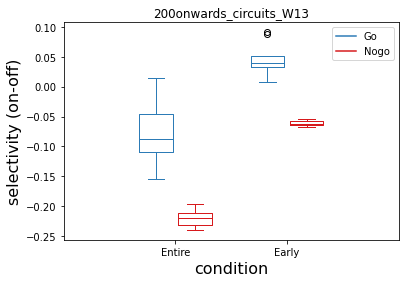

In [140]:
plot_panel_C(results_early1["all_window_sel"],results_entire1["all_window_sel"],results_none1["all_window_sel"],results_early2["all_window_sel"],results_entire2["all_window_sel"],results_none2["all_window_sel"],name="200onwards_circuits_W13")



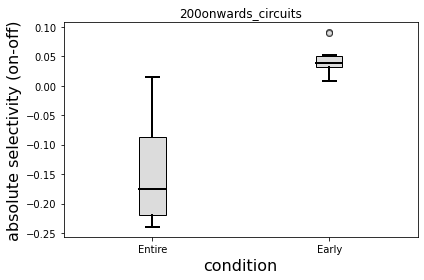

In [141]:
plot_panel_B(results_early1["all_window_sel"],results_entire1["all_window_sel"],results_none1["all_window_sel"],results_early2["all_window_sel"],results_entire2["all_window_sel"],results_none2["all_window_sel"],name="200onwards_circuits")


In [109]:
results_none_nc = run_model(condition=None, no_competition=True)
results_early_nc = run_model(condition="early", no_competition=True)
results_entire_nc = run_model(condition="entire", no_competition=True)



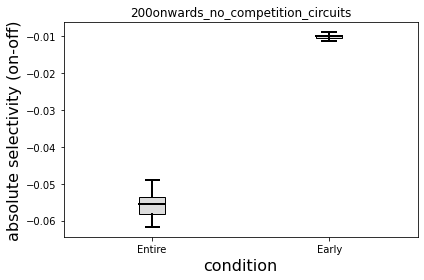

In [110]:
plot_panel_B(results_early_nc["all_window_sel"],results_entire_nc["all_window_sel"],results_none_nc["all_window_sel"],name="200onwards_no_competition_circuits")


In [111]:
results_none_l = run_model(circuit = "Go", condition=None, linear_activation=True)
results_early_l = run_model(circuit = "Go", condition="early", linear_activation=True)
results_entire_l = run_model(circuit = "Go", condition="entire", linear_activation=True)


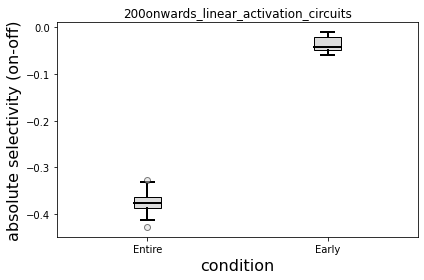

In [112]:
plot_panel_B(results_early_l["all_window_sel"],results_entire_l["all_window_sel"],results_none_l["all_window_sel"],name="200onwards_linear_activation_circuits")


In [113]:
def plot_phaseplane(S_1,S_2,W,name,ax,PV=False):
    # Meshgrid 
    x = np.arange(0,1,0.05) 
    y = np.arange(0,1,0.05)
    X,Y = np.meshgrid(x,y) 
    
    if PV == True:
        rate1 = phi(S_1 - W*y - 2.0)
        rate2 = phi(S_2 - W*x - 2.0)
        # Directional vectors
        u = -X + phi(S_2-W*Y - 2.0)
        v = -Y + phi(S_1-W*X - 2.0) 

    else:
        rate1 = phi(S_1 - W*y)
        rate2 = phi(S_2 - W*x)
        # Directional vectors
        u = -X + phi(S_2-W*Y)
        v = -Y + phi(S_1-W*X) 

    plt.quiver(x, y, u, v, color='k') 


    plt.plot(y,rate1, label= r'$r_1$ nullcline')
    plt.plot(rate2,x, label= r'$r_2$ nullcline')
    plt.title(r'%s: $W=%.1f$'%(name,W),fontsize=14) 


    plt.xlabel('rate 2',fontsize=14)
    plt.ylabel('rate 1',fontsize=14)
    plt.grid() 
    plt.legend()
    ax.set_aspect('equal')


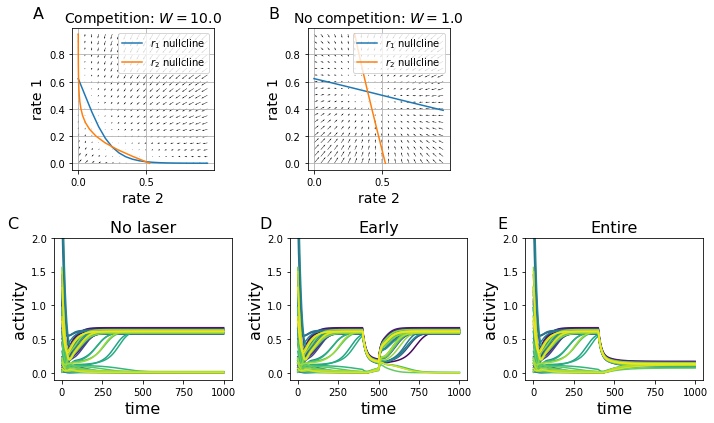

In [114]:
# plot appendix figure
M = 50
r1_Go_none = rates_1_n.T[:,:M]
r1_Go_early = rates_1_ea.T[:,:M]
r1_Go_entire = rates_1_en.T[:,:M]

W=10.0
plt.figure(figsize=(10,6))
ax1 = plt.subplot(231)
ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax1)

ax2 = plt.subplot(232) 
ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
          fontsize=16, va='top', ha='right')
W=1.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='No competition',ax=ax2)


ax3 = plt.subplot(234) 
ax3.text(-0.2, 1.15, 'C', transform=ax3.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_Go_none[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("No laser",fontsize=16)

ax4 = plt.subplot(235)
ax4.text(-0.1, 1.15, 'D', transform=ax4.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_Go_early[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Early",fontsize=16)

ax5 = plt.subplot(236)
ax5.text(-0.1, 1.15, 'E', transform=ax5.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_Go_entire[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Entire",fontsize=16)
plt.tight_layout()
plt.savefig('./Appendix_figure.pdf', bbox_inches='tight')


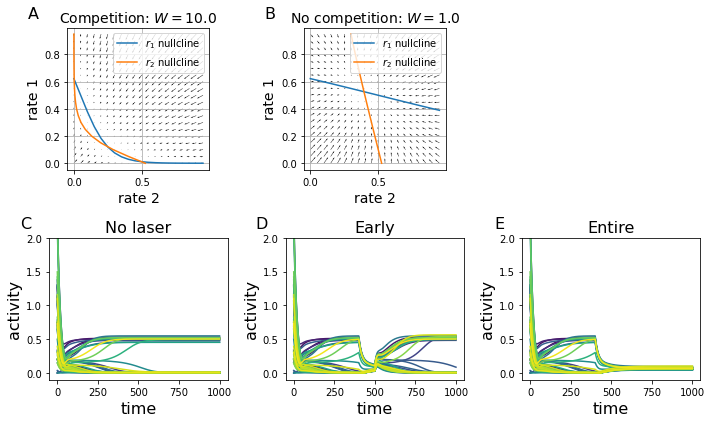

In [115]:
# plot appendix figure
M = 50
r1_NoGo_none = rates_1_n.T[:,M:]
r1_NoGo_early = rates_1_ea.T[:,M:]
r1_NoGo_entire = rates_1_en.T[:,M:]

W=10.0
plt.figure(figsize=(10,6))
ax1 = plt.subplot(231)
ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax1)

ax2 = plt.subplot(232) 
ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
          fontsize=16, va='top', ha='right')
W=1.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='No competition',ax=ax2)

ax3 = plt.subplot(234)
ax3.text(-0.1, 1.15, 'C', transform=ax3.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_NoGo_none[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("No laser",fontsize=16)

ax4 = plt.subplot(235)
ax4.text(-0.1, 1.15, 'D', transform=ax4.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_NoGo_early[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Early",fontsize=16)

ax5 = plt.subplot(236)
ax5.text(-0.1, 1.15, 'E', transform=ax5.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r1_NoGo_entire[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Entire",fontsize=16)
plt.tight_layout()
plt.savefig('./Appendix_figure_Nogo.pdf', bbox_inches='tight')


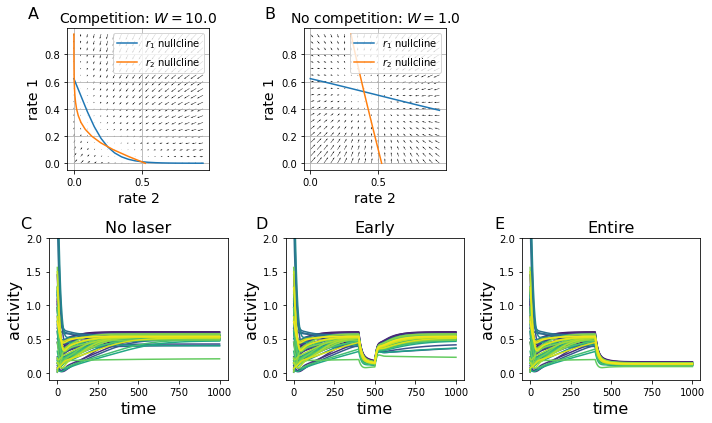

In [116]:
# plot appendix figure
M = 50
r2_Go_none = rates_2_n.T[:,:M]
r2_Go_early = rates_2_ea.T[:,:M]
r2_Go_entire = rates_2_en.T[:,:M]

W=10.0
plt.figure(figsize=(10,6))
ax1 = plt.subplot(231)
ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax1)

ax2 = plt.subplot(232) 
ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
          fontsize=16, va='top', ha='right')
W=1.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='No competition',ax=ax2)

ax3 = plt.subplot(234)
ax3.text(-0.1, 1.15, 'C', transform=ax3.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_Go_none[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("No laser",fontsize=16)

ax4 = plt.subplot(235)
ax4.text(-0.1, 1.15, 'D', transform=ax4.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_Go_early[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Early",fontsize=16)

ax5 = plt.subplot(236)
ax5.text(-0.1, 1.15, 'E', transform=ax5.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_Go_entire[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Entire",fontsize=16)
plt.tight_layout()
plt.savefig('./Appendix_figure_othercircuit.pdf', bbox_inches='tight')


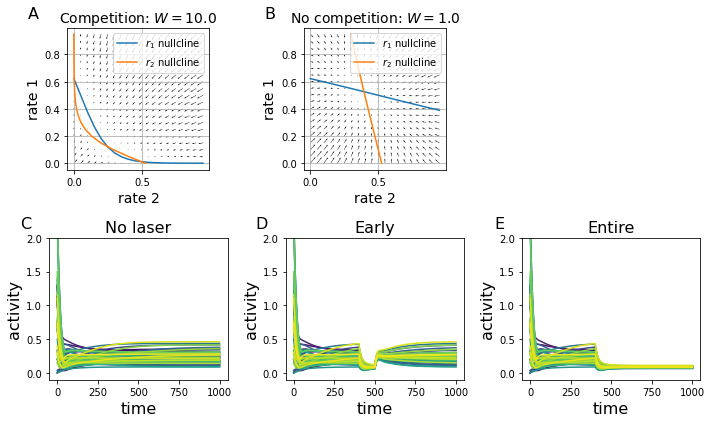

In [117]:
# plot appendix figure
M = 50
r2_NoGo_none = rates_2_n.T[:,M:]
r2_NoGo_early = rates_2_ea.T[:,M:]
r2_NoGo_entire = rates_2_en.T[:,M:]

W=10.0
plt.figure(figsize=(10,6))
ax1 = plt.subplot(231)
ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax1)

ax2 = plt.subplot(232) 
ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
          fontsize=16, va='top', ha='right')
W=1.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='No competition',ax=ax2)

ax3 = plt.subplot(234)
ax3.text(-0.1, 1.15, 'C', transform=ax3.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_NoGo_none[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("No laser",fontsize=16)

ax4 = plt.subplot(235)
ax4.text(-0.1, 1.15, 'D', transform=ax4.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_NoGo_early[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Early",fontsize=16)

ax5 = plt.subplot(236)
ax5.text(-0.1, 1.15, 'E', transform=ax5.transAxes,
          fontsize=16, va='top', ha='right')

for i in np.arange(M):
    plt.plot(r2_NoGo_entire[:,i],color=cm.viridis(i/M))
plt.xlabel('time',fontsize=16)
plt.ylabel('activity',fontsize=16)
plt.ylim(-0.1,2.0)
plt.title("Entire",fontsize=16)
plt.tight_layout()
plt.savefig('./Appendix_figure_Nogo_othercircuit.pdf', bbox_inches='tight')


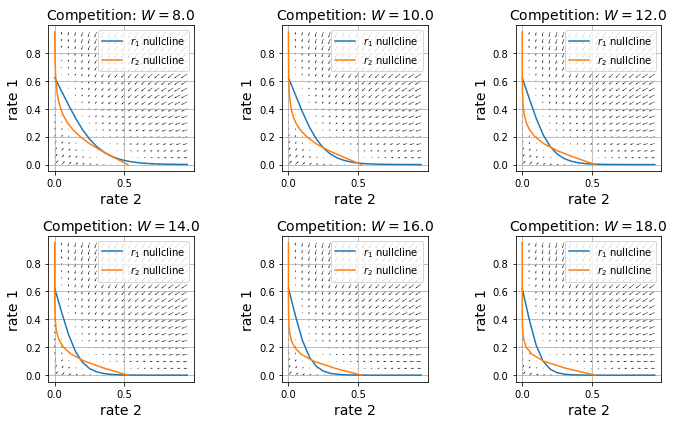

In [118]:
# plot robustness figure

W=8.0
plt.figure(figsize=(10,6))
ax1 = plt.subplot(231)
#ax1.text(-0.2, 1.15, 'A', transform=ax1.transAxes,
#          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax1)

ax2 = plt.subplot(232) 
#ax2.text(-0.2, 1.15, 'B', transform=ax2.transAxes,
#          fontsize=16, va='top', ha='right')
W=10.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax2)

ax3 = plt.subplot(233) 
#ax3.text(-0.2, 1.15, 'C', transform=ax3.transAxes,
#          fontsize=16, va='top', ha='right')
W=12.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax3)

W=14.0
ax4 = plt.subplot(234)
#ax4.text(-0.2, 1.15, 'D', transform=ax4.transAxes,
#          fontsize=16, va='top', ha='right')
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax4)

ax5 = plt.subplot(235) 
#ax5.text(-0.2, 1.15, 'E', transform=ax5.transAxes,
#          fontsize=16, va='top', ha='right')
W=16.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax5)

ax6 = plt.subplot(236) 
#ax6.text(-0.2, 1.15, 'F', transform=ax6.transAxes,
#          fontsize=16, va='top', ha='right')
W=18.0
plot_phaseplane(S_1=0.5,S_2=0.1,W=W,name='Competition',ax=ax6)


plt.tight_layout()
plt.savefig('./Appendix_figure_phaseplanes.pdf', bbox_inches='tight')
plt.savefig('./Appendix_figure_phaseplanes.png', bbox_inches='tight')
